In [1]:
import tensorflow as tf
import os
import sys
import go_datafile_reader
import model
import numpy as np
import model_eval

In [2]:
train_dir = "../data/input/train"
test_dir = "../data/input/test"
ckpt_path = "../data/working/test.ckpt"

In [3]:
train_files = []
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            train_files.append(filepath)

test_files = []
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            test_files.append(filepath)

print "num train: %d, num test: %d" %(len(train_files), len(test_files))

num train: 498, num test: 54


In [4]:
#note you may have to change the os limit for number of open files to use the RandomAccessFileReader
#you can do this with the command "sudo ulimit -n 20000"
#if sudo can't find the ulimit command try the following below
#sudo sh -c "ulimit -n 20000 && exec su $LOGNAME"

reader = go_datafile_reader.RandomAccessFileReader(train_files, board_size=9)
test_reader = go_datafile_reader.GoDatafileReader(test_files, board_size=9)

test_reader.num_epochs = 0
test_features = []
test_targets = []
test_move_numbers = []
while(test_reader.num_epochs == 0):
    test_move_numbers.append(test_reader.move_index)
    final_state, _, feature_cube = test_reader.read_sample()
    test_features.append(feature_cube)
    test_targets.append(final_state)

Initializing pointers in 498 datafiles, this may take a few minutes


In [5]:
print len(reader.open_files)

498


In [6]:
x, ownership = model.place_holders(board_size=9)
y_conv = model.model(x, board_size=9)
loss = model.loss_function(ownership, y_conv)
train_op = model.train_step(loss)

prediction = tf.round(y_conv)
correct_prediction = tf.equal(ownership, prediction)
correct_count = tf.reduce_sum(tf.cast(correct_prediction, "float"))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver(tf.all_variables())

ckpt_dir, _ = os.path.split(ckpt_path)
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt is not None:
    print("restore from previous checkpoint")
    saver.restore(sess, ckpt)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please use tf.global_variables instead.
restore from previous checkpoint
INFO:tensorflow:Restoring parameters from ../data/working/test.ckpt


In [7]:
training_accuracies = []
test_accuracies = []
for k in range(250):
    x_batch, y_batch = reader.get_batch(50)
    _, loss_value, y_value = sess.run([train_op, loss, y_conv], feed_dict={x:x_batch, ownership:y_batch})
    if k % 10 == 0:
        acc = accuracy.eval(feed_dict={x:x_batch, ownership:y_batch})
        training_accuracies.append(acc)
        print k, loss_value, acc
            
    if k % 1000 == 0:
        test_accuracy = model_eval.test_accuracy(test_features, test_targets, x, ownership, correct_count, board_size=9)
        test_accuracies.append(test_accuracy)
        print "Test accuracy: %f" %test_accuracy
    if k % 1000 == 0:
        print "Saving Checkpoint..."
        saver.save(sess, ckpt_path)
    

0 0.05513306 0.9145679
Test accuracy: 0.877502
Saving Checkpoint...
10 0.056059714 0.9138272
20 0.036940735 0.9508642
30 0.031176323 0.9565432
40 0.041148297 0.94222224
50 0.013252912 0.9866667
60 0.053553708 0.91728395
70 0.019226512 0.97481483
80 0.029635008 0.96074075
90 0.040903687 0.9387654
100 0.03554027 0.951358
110 0.021569101 0.9711111
120 0.03975025 0.9414815
130 0.03246699 0.9562963
140 0.043855127 0.94222224
150 0.032503523 0.9604938
160 0.04407858 0.93777776
170 0.034749113 0.95160496
180 0.049325768 0.917037
190 0.0434939 0.92938274
200 0.046032373 0.93333334
210 0.028576117 0.95555556
220 0.033097375 0.95753086
230 0.03186476 0.9582716
240 0.032864366 0.95555556


In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def rolling_mean(number_list, window = 20):
    means = np.zeros(len(number_list))
    for i in xrange(len(means)):
        sub_window = number_list[i-window+1:i+1]
        means[i] = np.mean(sub_window)
    return means

25


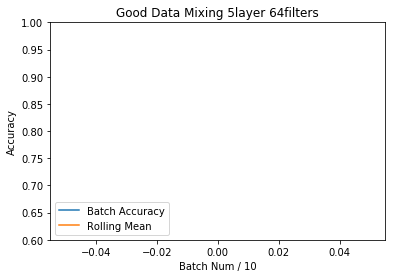

In [10]:
print len(training_accuracies)
means = rolling_mean(test_accuracies, 20)
plt.plot(test_accuracies, label="Batch Accuracy")
plt.plot(means, label= "Rolling Mean")
plt.title("Good Data Mixing 5layer 64filters")
plt.xlabel("Batch Num / 10")
plt.ylabel("Accuracy")
plt.ylim([0.6,1])
plt.legend(loc=3)
plt.show()

In [20]:
accuracies = []
y_trues = []
y_preds = []
y_vals = []
feature_cubes = []
for i in xrange(len(test_features)):
    if i%500 == 0:
        print i
    x_, y_ = test_features[i], test_targets[i]
    y_val, y_pred, acc = sess.run([y_conv, prediction, accuracy], feed_dict={x:[x_], ownership:[y_]})
    accuracies.append(acc)
    y_trues.append(np.reshape(y_, [9,9]))
    y_preds.append(np.reshape(y_pred[0], [9,9]))
    y_vals.append(np.reshape(y_val[0], [9,9]))
    feature_cubes.append(x_)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [23]:
idx = 432
y_pred = y_preds[idx]
y_val = y_vals[idx]
y_true = y_trues[idx]
feature_cube = feature_cubes[idx]

print(test_move_numbers[idx], accuracies[idx])
model_eval.print_info(feature_cube, y_pred, y_val, y_true, board_size=9)

(36, 0.91358024)
**OX*****   OOOOOOOOX   000110159   OOOOOOOOO
*XOX**X**   OOOOOOOXX   000321299   OOOOOOOOO
**OXXXX**   OOOXOOOXX   000920457   OOOOOOOOO
*O*OOOOX*   OOOOOOOXO   000000071   OOOOOOOOO
**O***OXO   OOOOOOOOO   000000010   OOOOOOOOO
*XO*OO*O*   OOOOOOOOO   000000000   OOOOOOOOO
*O*O*XO**   OOOOOOOOO   000000000   OOOOOOOOO
*********   OOOOOOOOO   000000000   OOOOOOOOO
*********   OOOOOOOOO   000000000   OOOOOOOOO


In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame()
df["Move Num"] = test_move_numbers
df["Accuracy"] = accuracies
grouped = df.groupby("Move Num").aggregate(np.mean)


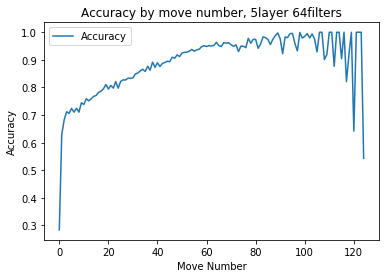

In [26]:
grouped.plot()
plt.title("Accuracy by move number, 5layer 64filters")
plt.xlabel("Move Number")
plt.ylabel("Accuracy")
plt.show()

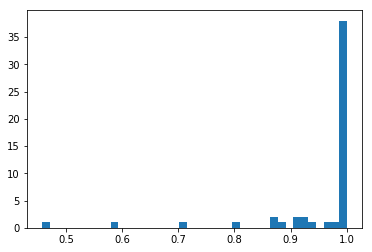

In [28]:
plot = plt.hist(df[df["Move Num"] == 70]["Accuracy"].values, bins = 40)
plt.show()